In [1]:
!pip install openpyxl

/opt/conda/envs/umd-spring-2024/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2024-05-07 14:32:11.370400: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-07 14:32:12.193428: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


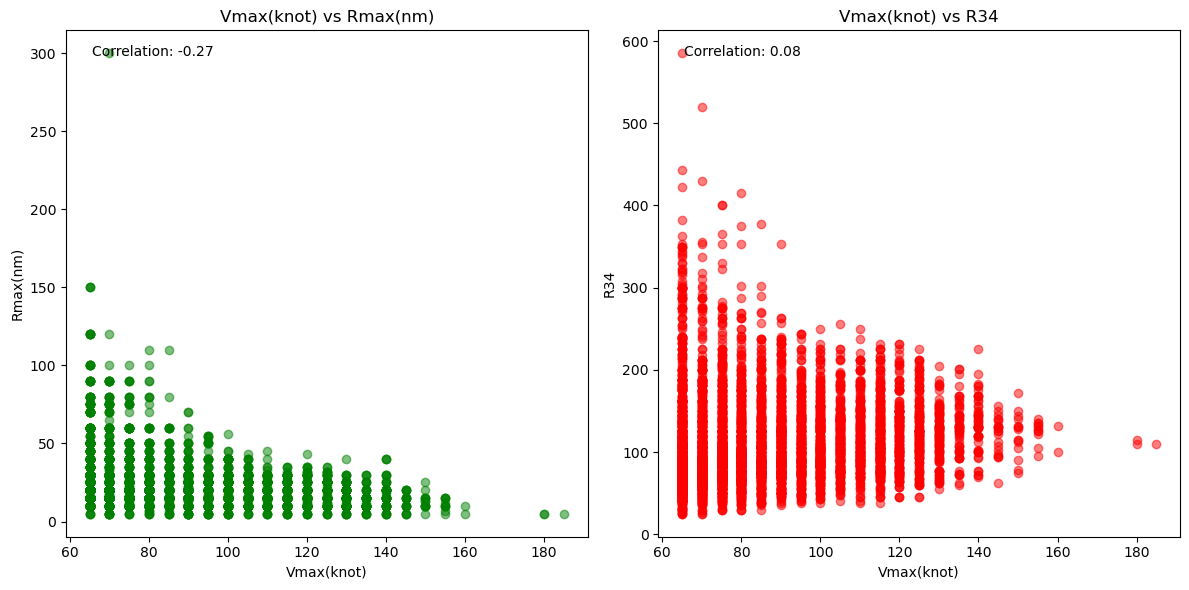

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import keras
import sklearn

# 载入Excel文件
file_path = 'TC_observed_data_sizes.xlsx'
sheets = ['CP_noFillValue', 'EP_noFillValue', 'AL_noFillValue']

# 更新列名映射
correct_columns = ['Vmax(knot)', 'Rmax(nm)', 'MinSLP(hPa)', 'R34', 'R50', 'R64']

# 重新读取数据并计算统计量
stats_updated = {}
dataframes = {}
for sheet in sheets:
    # 对EP_noFillValue使用特殊处理，因为其列名不规范
    if sheet == 'EP_noFillValue':
        df = pd.read_excel(file_path, sheet_name=sheet)
        df.columns = ['name', 'column2', 'year', 'lat(N)', 'lon(W)', 'Vmax(knot)', 'MinSLP(hPa)', 'Rmax(nm)',
                      'eye diameter(nm)', 'pressure outside(hPa)', 'Radius of outside(nm)', 'R34', 'R50', 'R64', 
                      'type', 'distance of Land']
    else:
        df = pd.read_excel(file_path, sheet_name=sheet, usecols=correct_columns)
    dataframes[sheet] = df
    stats_updated[sheet] = {col: {'max': df[col].max(), 'min': df[col].min(), 'mean': df[col].mean(), 'var': df[col].var()} for col in correct_columns}

# 将所有工作表的数据合并
combined_df = pd.concat([dataframes[sheet][correct_columns] for sheet in sheets], ignore_index=True)

# 计算Vmax(knot)与Rmax(nm)的相关系数
corr_vmax_rmax = combined_df['Vmax(knot)'].corr(combined_df['Rmax(nm)'])
# 计算Vmax(knot)与R34的相关系数
corr_vmax_r34 = combined_df['Vmax(knot)'].corr(combined_df['R34'])

# 绘制Vmax与Rmax, Vmax与R34的散点图
plt.figure(figsize=(12, 6))

# Vmax与Rmax
plt.subplot(1, 2, 1)
plt.scatter(combined_df['Vmax(knot)'], combined_df['Rmax(nm)'], color='green', alpha=0.5)
plt.title('Vmax(knot) vs Rmax(nm)')
plt.xlabel('Vmax(knot)')
plt.ylabel('Rmax(nm)')
# 在图上标注相关系数
plt.text(0.05, 0.95, f'Correlation: {corr_vmax_rmax:.2f}', transform=plt.gca().transAxes)

# Vmax与R34
plt.subplot(1, 2, 2)
plt.scatter(combined_df['Vmax(knot)'], combined_df['R34'], color='red', alpha=0.5)
plt.title('Vmax(knot) vs R34')
plt.xlabel('Vmax(knot)')
plt.ylabel('R34')
# 在图上标注相关系数
plt.text(0.05, 0.95, f'Correlation: {corr_vmax_r34:.2f}', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()


In [3]:
combined_df['R34'].describe()

count    5724.000000
mean      113.410858
std        52.153293
min        25.000000
25%        77.500000
50%       102.500000
75%       137.500000
max       585.000000
Name: R34, dtype: float64

In [4]:
R34_standard = 300  #300
Rmax_standard = 100  #100
Vmax_standard = 150 #150
# removed the abnormal error of data
count_R34 = (combined_df['R34'] > R34_standard).sum() 
print(count_R34)
# removed the abnormal error of data
count_Rmax = (combined_df['Rmax(nm)'] > Rmax_standard).sum() 
print(count_Rmax)
# removed the abnormal error of data
count_Vmax = (combined_df['Vmax(knot)'] > Vmax_standard).sum() 
print(count_Vmax)

45
14
16


In [5]:
# organize our data into an xarray dataset
event = np.arange(5724)
ds_origin = xr.Dataset(
    {
        "Vmax": ("event", combined_df['Vmax(knot)']),
        "Rmax": ("event", combined_df['Rmax(nm)']),
        "R34": ("event", combined_df['R34']),
    },
    {"event": event},
)
ds = ds_origin.where((ds_origin['Rmax'] <= Rmax_standard) & (ds_origin['Vmax'] <= Vmax_standard) & (ds_origin['R34'] <= R34_standard), drop=True)
ds

<xarray.Dataset>
Dimensions:  (event: 5654)
Coordinates:
  * event    (event) int64 0 1 2 3 4 5 6 ... 5717 5718 5719 5720 5721 5722 5723
Data variables:
    Vmax     (event) float64 65.0 70.0 75.0 100.0 115.0 ... 75.0 70.0 65.0 65.0
    Rmax     (event) float64 15.0 15.0 15.0 15.0 15.0 ... 40.0 40.0 40.0 40.0
    R34      (event) float64 42.5 106.2 103.8 120.0 ... 277.5 277.5 290.0 285.0

In [6]:
# if we prefer a pandas dataframe, we can easily convert
df = ds.to_dataframe()
df.head() # few first few rows

,Vmax,Rmax,R34
event,,,
0,65.0,15.0,42.50
1,70.0,15.0,106.25
2,75.0,15.0,103.75
3,100.0,15.0,120.00
4,115.0,15.0,122.50


In [7]:
# lets view some simple statistics of tmin for each location
# we can group by location to more easily generate the stats
df['Vmax'].describe()

count    5654.000000
mean       87.980191
std        20.256116
min        65.000000
25%        70.000000
50%        85.000000
75%       100.000000
max       150.000000
Name: Vmax, dtype: float64

In [8]:
df['Rmax'].describe()

count    5654.000000
mean       21.711885
std        12.398305
min         5.000000
25%        15.000000
50%        20.000000
75%        25.000000
max       100.000000
Name: Rmax, dtype: float64

In [9]:
df['R34'].describe()

count    5654.000000
mean      111.220375
std        47.094087
min        25.000000
25%        77.500000
50%       100.000000
75%       137.500000
max       300.000000
Name: R34, dtype: float64

<Axes: ylabel='Frequency'>

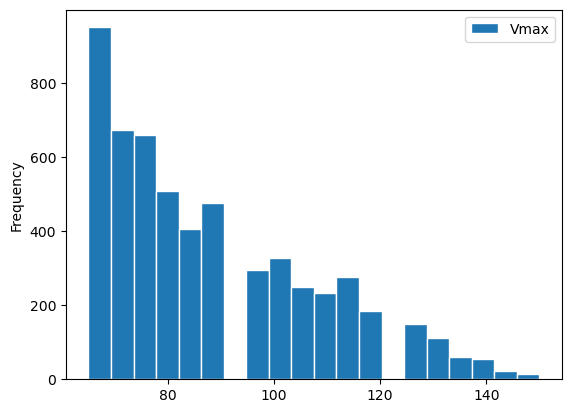

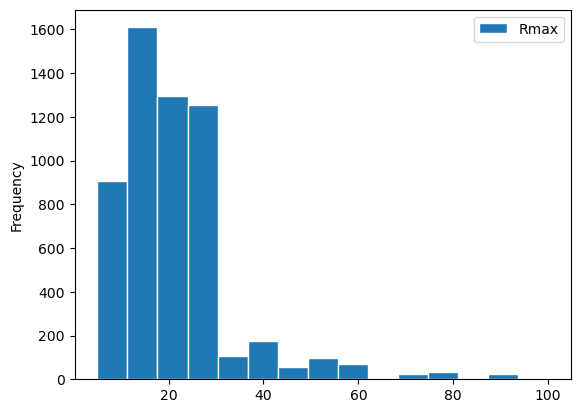

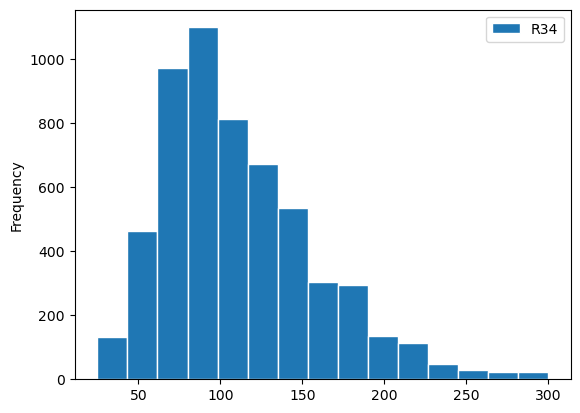

In [10]:
# we may be interested in the number of times certain
# temperatures occur, which we can view with a histogram
# here we are viewing this just for Iowa and tmin
# Reducing bins can make thicker cylinder.
ds['Vmax'].to_dataframe().plot.hist(
    edgecolor='w', bins=20)
ds['Rmax'].to_dataframe().plot.hist(
    edgecolor='w', bins=15)
ds['R34'].to_dataframe().plot.hist(
    edgecolor='w', bins=15)

In [11]:
# I prefer used standardized (not normalized) for my data.
#  PCA is not necessary for my project since it is a 1-D timeseries. 
#mean_Vmax = ds['Vmax'].mean(dim='event')
#mean_Rmax = ds['Rmax'].mean(dim='event')
#mean_R34 = ds['R34'].mean(dim='event')

#anomalies_Vmax = ds['Vmax'] - mean_Vmax
#anomalies_Rmax = ds['Rmax'] - mean_Rmax
#anomalies_R34 = ds['R34'] - mean_R34

# 将计算出的异常值添加回原始数据集中
#ds['anomalies_Vmax'] = anomalies_Vmax
#ds['anomalies_Rmax'] = anomalies_Rmax
#ds['anomalies_R34'] = anomalies_R34

#ds['anomalies_Vmax'].to_dataframe().plot.hist(
#    edgecolor='w', bins=20)

In [12]:
def z_score(da):
    """
    Compute z-score for training data.
    Normalizing data for ML model training.
    Args: da (array): Array of training variable.
    """
    return (da - np.mean(da)) / np.std(da), np.mean(da), np.std(da)

# when applied to test data, input the mean and std from training set
def z_score_test(da, mn, std):
    """
    Compute z-score for training data.
    Normalizing data for ML model training.
    Args: da (array): Array of training variable.
    """
    return (da - mn) / std

# the function applied to the training data needs to return the
# min and max values
def min_max_scale(da):
    """
    Scale training data by minimum and maximum values.
    Args: da (array): Array of training variable.
    """
    return (da - np.min(da)) / (
        np.max(da) - np.min(da)), np.min(da), np.max(da)

# when applied to test data, input the min and max from training set
def min_max_scale_test(da, min, max):
    """
    Scale training data by minimum and maximum values.
    Args: da (array): Array of training variable.
    """
    return (da - min) / (max - min)

In [13]:
# apply zscore to first location's tmax
zscore, mn, std = z_score(ds['Vmax'])
print(mn.values, std.values)

87.98019101521047 20.254324702479355


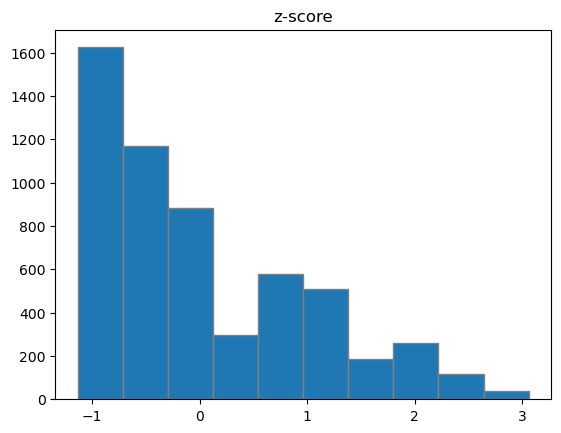

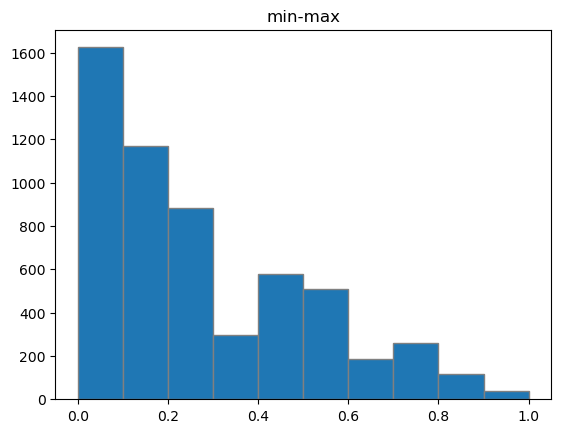

In [14]:
# notice that the rescaling just modifies the x-axis values
plt.hist(z_score(ds['Vmax'])[0], edgecolor='grey')
plt.title('z-score')
plt.show()

plt.hist(min_max_scale(ds['Vmax'])[0], edgecolor='grey')
plt.title('min-max')
plt.show()

In [15]:
# helper function for random split
# I remodified this to two data and one label
def random_split(data1, data2, label, split=0.3, seed=0):
    """
    Help splitting data randomly for training and testing.
    """
    np.random.seed(seed)
    da_indx = np.random.permutation(data1.shape[0])
    data1  = data1[da_indx.astype(int)]
    data2  = data2[da_indx.astype(int)]
    label = label[da_indx.astype(int)]
    init_range = int(data1.shape[0] * (1 - 0.3))
    return (
        data1[:init_range], data2[:init_range], label[:init_range],
        data1[init_range:], data2[init_range:], label[init_range:]
        )

In [16]:
train_X1, train_X2, train_Y, test_X1, test_X2, test_Y = random_split(
    ds['Vmax'],
    ds['Rmax'],
    ds['R34'],split=0.3, seed=0)

In [17]:
print(train_X1.shape, train_X2.shape, train_Y.shape)
print(test_X1.shape, test_X2.shape,  test_Y.shape)

(3957,) (3957,) (3957,)
(1697,) (1697,) (1697,)


In [18]:
# apply zscore to first location's tmax
zscore_X1, mn_X1, std_X1 = z_score(train_X1)
print(mn_X1.values, std_X1.values)
zscore_X2, mn_X2, std_X2 = z_score(train_X2)
print(mn_X2.values, std_X2.values)
zscore_Y, mn_Y, std_Y = z_score(train_Y)
print(mn_Y.values, std_Y.values)

88.19560272934041 20.388361079239843
21.81779125600202 12.61012773848419
111.55863027546121 47.3144802212712


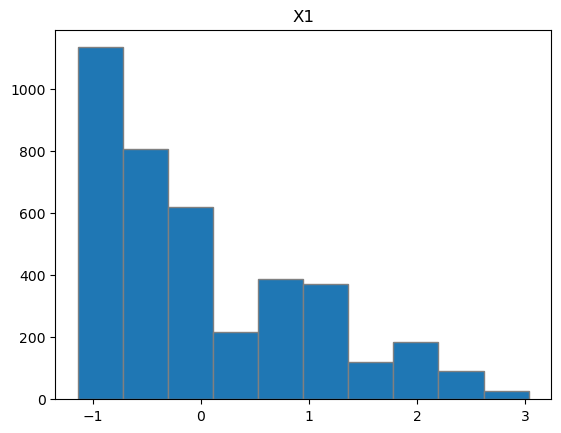

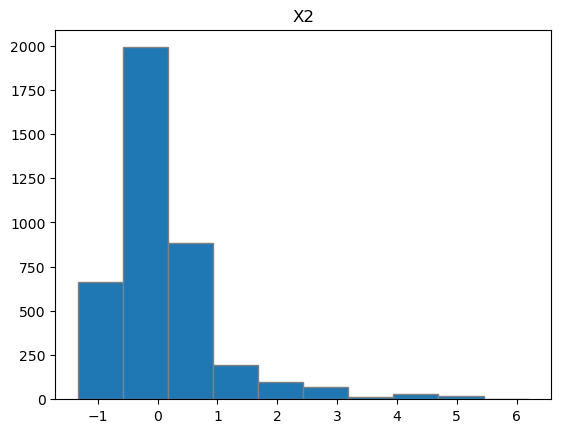

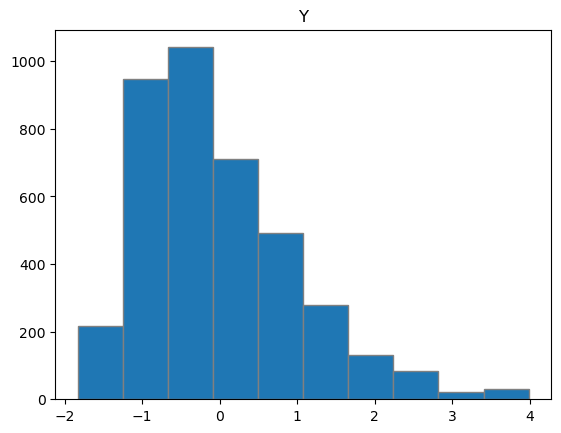

In [19]:
# notice that the rescaling just modifies the x-axis values
plt.hist(z_score(train_X1)[0], edgecolor='grey')
plt.title('X1')
plt.show()
plt.hist(z_score(train_X2)[0], edgecolor='grey')
plt.title('X2')
plt.show()
plt.hist(z_score(train_Y)[0], edgecolor='grey')
plt.title('Y')
plt.show()

In [20]:
import keras
from keras.layers import Input, Dense, concatenate
from keras.models import Model
from keras.optimizers import SGD

def build_model(hp):
    # 定义两个输入层，每个输入变量一个
    input_layer = Input(shape=(2,), name='input1')

    activation_function = 'tanh'
    max_num = 32
    num_layers = 8
    # 对于每个输入，使用可调的隐藏层
    hp_units = []
    for i in range(num_layers):
      hp_units.append(hp.Int('units_%d' % i, min_value=2, max_value=max_num, step=1))

    hidden_layers = []
    for i in range(num_layers):
      pre_layer = input_layer if i == 0 else hidden_layers[i - 1]
      hidden_layers.append(
          Dense(units=hp_units[i], activation=activation_function)(pre_layer))

    # 定义输出层
    output = Dense(1, activation=None)(hidden_layers[num_layers - 1])

    # 创建模型，这次模型有两个输入
    model = Model(inputs=[input_layer], outputs=output)

    # 优化学习率
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=5e-3, sampling='log')

    # 编译模型
    model.compile(optimizer=SGD(learning_rate=learning_rate), loss='mse')

    return model


In [21]:
# keras-tuner doesn't come installed in colab so lets install
!pip install keras-tuner -q

/opt/conda/envs/umd-spring-2024/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [22]:
import keras_tuner

In [23]:
build_model(keras_tuner.HyperParameters())

<Functional name=functional_1, built=True>

In [24]:
#tuner = keras_tuner.RandomSearch(
#    hypermodel=build_model,
#    objective="val_loss",
#    max_trials=100,
#    seed=123,
#    overwrite=True
#)

tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=20,
    num_initial_points=20,
    alpha=0.0001,
    beta=2.6,
    seed=123,
    # hyperparameters=None,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=0,
    max_consecutive_failed_trials=3,
    overwrite=True
)

In [25]:
tuner.search_space_summary()

Search space summary
Default search space size: 9
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 32, 'step': 1, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 32, 'step': 1, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 32, 'step': 1, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 32, 'step': 1, 'sampling': 'linear'}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 32, 'step': 1, 'sampling': 'linear'}
units_5 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 32, 'step': 1, 'sampling': 'linear'}
units_6 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 32, 'step': 1, 'sampling': 'linear'}
units_7 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 32, 'step': 1, 'sampling': 'linear'}
learning_rate (Float)


In [26]:
label_train = zscore_Y.values
input_train = np.transpose(np.array([zscore_X1.values, zscore_X2.values], dtype=np.float32))
input_train.shape

(3957, 2)

In [27]:
number_epochs = 32
tuner.search(
    input_train,  # 传递两个输入数组
    label_train,  # 标签
    epochs=number_epochs,
    batch_size=32,
    validation_split=0.1
)

Trial 20 Complete [00h 00m 07s]
val_loss: 0.6147738099098206

Best val_loss So Far: 0.6143515110015869
Total elapsed time: 00h 02m 20s


In [28]:
models = tuner.get_best_models(num_models=2)
models
best_model = models[0]
best_model.summary()
# Get the top hyperparameters.
best_hps = tuner.get_best_hyperparameters(num_trials=1)
model = build_model(best_hps[0])

# number_epochs = 30
# 模型训练
history = model.fit(
    input_train,  # 传递两个输入数组
    label_train,  # 标签
    epochs=number_epochs,
    batch_size=32,
    validation_split=0.1
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input1 (InputLayer)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 22)             │            66 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            69 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │           135 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 11)             │           176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 25)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 21)             │           546 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 27)             │           594 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,946 (7.60 KB)

 Trainable params: 1,946 (7.60 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9594 - val_loss: 0.6907
Epoch 2/32
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5865 - val_loss: 0.6391
Epoch 3/32
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6222 - val_loss: 0.6314
Epoch 4/32
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6248 - val_loss: 0.6297
Epoch 5/32
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6199 - val_loss: 0.6597
Epoch 6/32
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6459 - val_loss: 0.6450
Epoch 7/32
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6367 - val_loss: 0.6279
Epoch 8/32
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6374 - val_loss: 0.6338
Epoch 9/32
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6009 - val_loss: 0.6259
Epoch 10/32
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6319 - val_loss: 0.6371
Epoch 11/32
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6758 - val_loss: 0.6277
Epoch 12/32
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

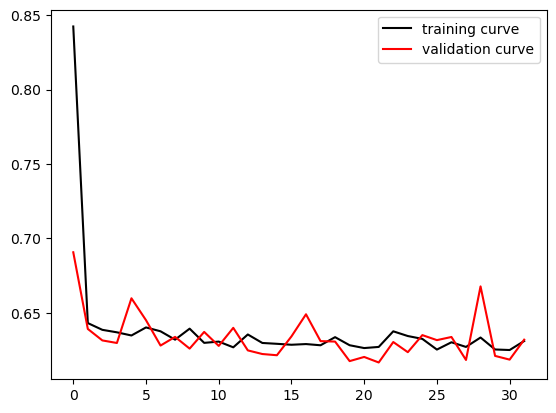

In [29]:
plt.plot(range(0,number_epochs), history.history['loss'], c='k', label = "training curve")
plt.plot(range(0,number_epochs), history.history['val_loss'], c='r', label = "validation curve")
plt.legend()
plt.show()

In [30]:
predictions_train = model.predict(
    x=input_train,
)
predictions_train.shape


124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


(3957, 1)

/tmp/ipykernel_17573/1452607174.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(z_score(train_X1)[0], z_score(train_X2)[0], z_score(train_Y)[0], marker='o', cmap='viridis')
/tmp/ipykernel_17573/1452607174.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(z_score(train_X1)[0], z_score(train_X2)[0], predictions_train[0], marker='o', cmap='viridis')


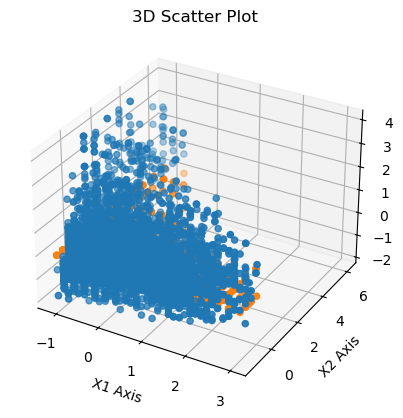

In [31]:
from mpl_toolkits.mplot3d import Axes3D
# 创建图形
fig = plt.figure()

# 创建3D坐标轴
ax = fig.add_subplot(111, projection='3d')

# 在3D坐标轴上绘制散点图
ax.scatter(z_score(train_X1)[0], z_score(train_X2)[0], z_score(train_Y)[0], marker='o', cmap='viridis')
ax.scatter(z_score(train_X1)[0], z_score(train_X2)[0], predictions_train[0], marker='o', cmap='viridis')

# 设置坐标轴标签
ax.set_xlabel('X1 Axis')
ax.set_ylabel('X2 Axis')
ax.set_zlabel('Y Axis')

# 设置标题
ax.set_title('3D Scatter Plot')

# 显示图形
plt.show()

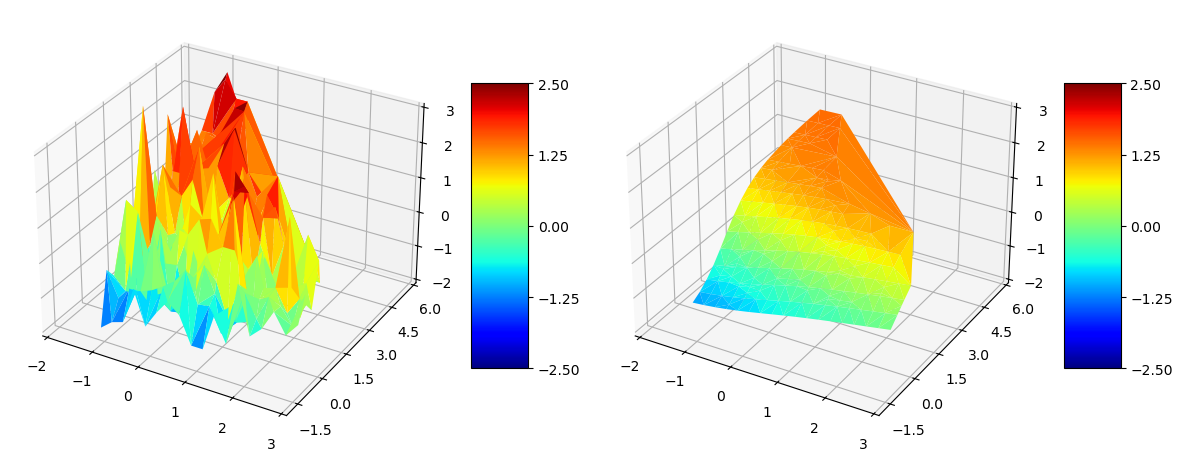

In [40]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import MaxNLocator, LinearLocator

#画曲面图
# 创建网格来评估模型
x=z_score(train_X1)[0]
y=z_score(train_X2)[0]
z=z_score(train_Y)[0]

z1=predictions_train.ravel()

# 创建一个图形和两个子图
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(12, 6))

# 设置全局颜色范围，确保所有子图使用相同的范围
vmin = -2.5
vmax = 2.5

# 第一个子图
surf1 = ax1.plot_trisurf(x, y, z, cmap=cm.jet, linewidth=0, vmin=vmin, vmax=vmax)
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5, orientation='vertical', ticks=LinearLocator(numticks=5))

ax1.xaxis.set_major_locator(MaxNLocator(5))
ax1.yaxis.set_major_locator(MaxNLocator(6))
ax1.zaxis.set_major_locator(MaxNLocator(5))

ax1.set_xlim([-2, 3])
ax1.set_ylim([-2, 6])
ax1.set_zlim([-2, 3])

# 第二个子图
surf2 = ax2.plot_trisurf(x, y, z1, cmap=cm.jet, linewidth=0, vmin=vmin, vmax=vmax)
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5, orientation='vertical', ticks=LinearLocator(numticks=5))

ax2.xaxis.set_major_locator(MaxNLocator(5))
ax2.yaxis.set_major_locator(MaxNLocator(6))
ax2.zaxis.set_major_locator(MaxNLocator(5))

ax2.set_xlim([-2, 3])
ax2.set_ylim([-2, 6])
ax2.set_zlim([-2, 3])

# 调整布局
plt.tight_layout()
plt.show()

In [33]:
zscore_test_X1 = z_score_test(test_X1, mn_X1, std_X1)
zscore_test_X2 = z_score_test(test_X2, mn_X2, std_X2)
zscore_test_Y = z_score_test(test_Y, mn_Y, std_Y)


input_test1 = zscore_test_X1.values
label_test = zscore_test_Y.values
input_test2 = zscore_test_X2.values

In [34]:
input_test = np.transpose(np.array([input_test1, input_test2], dtype=np.float32))
# to predict, use predict call
predictions = model.predict(
    x=input_test,
)

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step


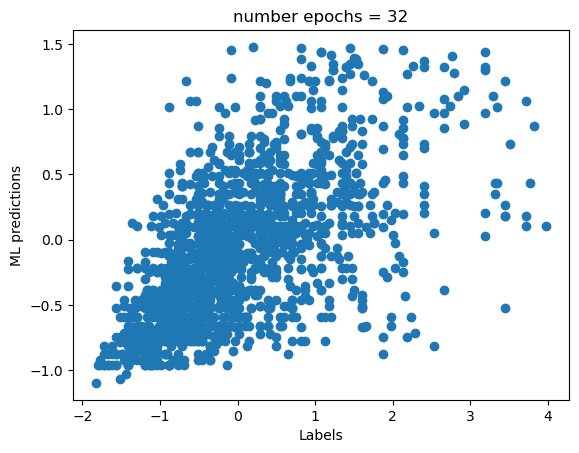

In [35]:
plt.scatter(label_test, predictions)
plt.xlabel('Labels')
plt.ylabel('ML predictions')
plt.title(f'number epochs = {number_epochs}')
plt.show()

In [36]:
# correlation coefficeint
predictions_flattened = predictions.flatten()
corr = np.corrcoef(predictions_flattened, label_test)

print(np.mean(np.square(label_test - predictions_flattened)))
print(corr[0,1])

0.6209706910181519
0.6069283906697845


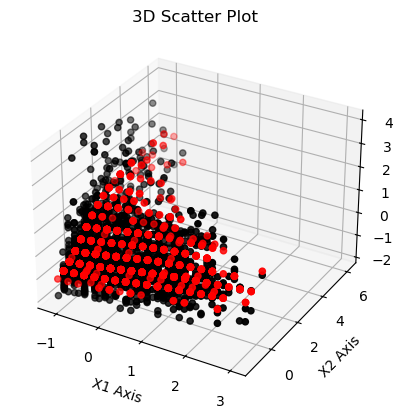

In [37]:
from mpl_toolkits.mplot3d import Axes3D
# 创建图形
fig = plt.figure()

# 创建3D坐标轴
ax = fig.add_subplot(111, projection='3d')

# 在3D坐标轴上绘制散点图
ax.scatter(input_test1, input_test2, label_test, marker='o', color='black')
ax.scatter(input_test1, input_test2, predictions_flattened, marker='o', color='red')

# 设置坐标轴标签
ax.set_xlabel('X1 Axis')
ax.set_ylabel('X2 Axis')
ax.set_zlabel('Y Axis')

# 设置标题
ax.set_title('3D Scatter Plot')

# 显示图形
plt.show()

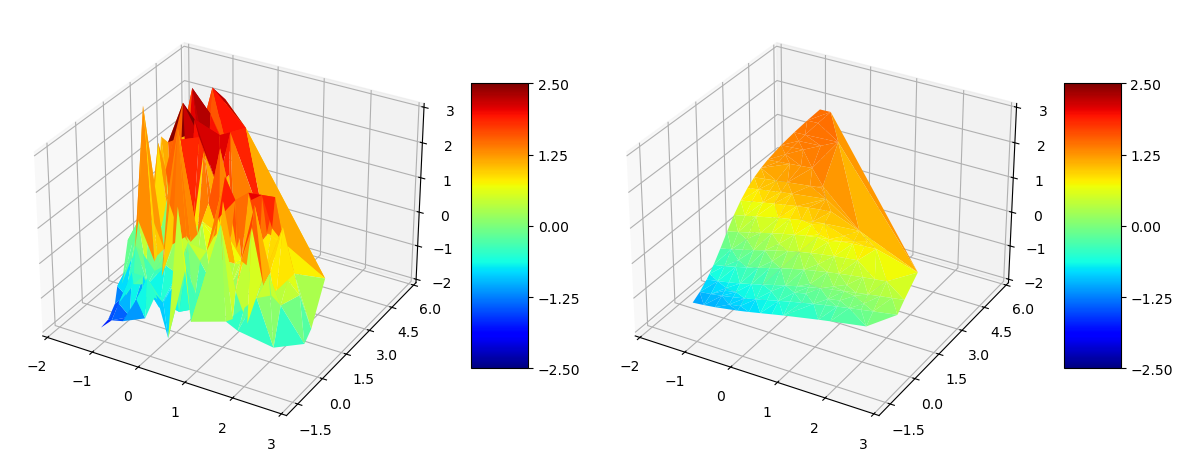

In [41]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import MaxNLocator, LinearLocator

#画曲面图
# 创建网格来评估模型
x=input_test1
y=input_test2
z=label_test

z1=predictions_flattened

# 创建一个图形和两个子图
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(12, 6))

# 设置全局颜色范围，确保所有子图使用相同的范围
vmin = -2.5
vmax = 2.5

# 第一个子图
surf1 = ax1.plot_trisurf(x, y, z, cmap=cm.jet, linewidth=0, vmin=vmin, vmax=vmax)
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5, orientation='vertical', ticks=LinearLocator(numticks=5))

ax1.xaxis.set_major_locator(MaxNLocator(5))
ax1.yaxis.set_major_locator(MaxNLocator(6))
ax1.zaxis.set_major_locator(MaxNLocator(5))

ax1.set_xlim([-2, 3])
ax1.set_ylim([-2, 6])
ax1.set_zlim([-2, 3])


# 第二个子图
surf2 = ax2.plot_trisurf(x, y, z1, cmap=cm.jet, linewidth=0, vmin=vmin, vmax=vmax)
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5, orientation='vertical', ticks=LinearLocator(numticks=5))

ax2.xaxis.set_major_locator(MaxNLocator(5))
ax2.yaxis.set_major_locator(MaxNLocator(6))
ax2.zaxis.set_major_locator(MaxNLocator(5))

ax2.set_xlim([-2, 3])
ax2.set_ylim([-2, 6])
ax2.set_zlim([-2, 3])


# 调整布局
plt.tight_layout()
plt.show()